## TPU Based Model for Cassava Leaf Disease Classification
I created the following notebook demonstrating how you can train on TPUs and run inference.

This was done for a competition submission in the [Cassava Leaf Disease Classification competition](https://www.kaggle.com/c/cassava-leaf-disease-classification)<br> Since this is a code competition with a hidden test set, internet and TPUs cannot be enabled on the submission notebook. Therefore TPUs are only available for training models.

I started with the notebook [Jesse](https://www.kaggle.com/jessemostipak) wrote [Getting Started: TPUs + Cassava Leaf Disease](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) this is the basis for the model I trained.

At the end of this notebook in my copy I added `model.save('<yourModelName>.h5')`. <br>
I then created a new [dataset](https://www.kaggle.com/peretzcohen/cassavaleafdiseasetpumodel) using the output of the notebook, the output is the model that was trained on TPUs.

For the next part I referenced the strategy and code of [Devon](https://www.kaggle.com/devonstanfield) in the notebook [cassava-infer](https://www.kaggle.com/devonstanfield/cassava-infer). <br> The strategy was to utilize my previously generated model and create a submission file for the competition.

In the new notebook, in order to submit to the competition, ensure that the Accelerator and Internet are disabled as seen in the screenshot below.

Happy coding!


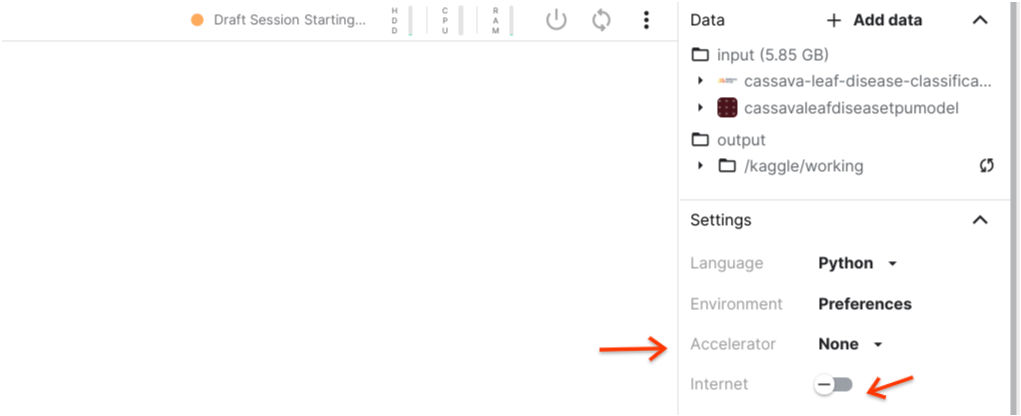

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [ ]:
model = tf.keras.models.load_model('../input/cassavaleafdiseasetpumodel/leafKnowledge.h5')
    


In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [512, 512]


In [ ]:
def _parse_function(proto):
    # feature_description needs to be defined since datasets use graph-execution
    # - its used to build their shape and type signature
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'target': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }

    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image = tf.image.decode_jpeg(parsed_features['image'], channels=3)
    image = tf.cast(image, tf.float32) # :: [0.0, 255.0]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    target = tf.one_hot(parsed_features['target'], depth=5)
    image_id = parsed_features['image_name']
    return image, target, image_id

def _preprocess_fn(image, label, image_id):
    image = image / 255.0
    image = tf.image.resize(image, (224, 224))
    label = tf.concat([label, [0]], axis=0)
    return image, label, image_id

In [ ]:
def load_dataset(tfrecords_fnames):
    raw_ds = tf.data.TFRecordDataset(tfrecords_fnames, num_parallel_reads=AUTO)
    parsed_ds = raw_ds.map(_parse_function, num_parallel_calls=AUTO)
    parsed_ds = parsed_ds.map(_preprocess_fn, num_parallel_calls=AUTO)
    return parsed_ds
def build_valid_ds(valid_fnames):
    ds = load_dataset(valid_fnames)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds
TEST_PATH = '../input/cassava-leaf-disease-classification/test_tfrecords/'
valid_fnames = [TEST_PATH + fname for fname in os.listdir(TEST_PATH)]
test_ds = build_valid_ds(valid_fnames)
preds = model.predict(test_ds)
labels = tf.argmax(preds, axis=-1)
labels = labels.numpy()

In [ ]:
test_ds = build_valid_ds(valid_fnames)
names = []
for item in test_ds:
    names.append(item[2].numpy())
names = np.concatenate(names)
names = [name.decode() for name in names]
submission_df = pd.DataFrame({'image_id':names, 'label':labels})
submission_df.to_csv("submission.csv", index=False)
!head submission.csv